In [3]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('Chinook.db')
cursor = conn.execute("select * from Artist LIMIT 10")
rows = cursor.fetchall()

rows

[(1, 'AC/DC'),
 (2, 'Accept'),
 (3, 'Aerosmith'),
 (4, 'Alanis Morissette'),
 (5, 'Alice In Chains'),
 (6, 'Antônio Carlos Jobim'),
 (7, 'Apocalyptica'),
 (8, 'Audioslave'),
 (9, 'BackBeat'),
 (10, 'Billy Cobham')]

In [4]:
data = ''
with open('Chinook_db_description.txt','r') as file:
    data= file.readlines()

text = " ".join(data)
print(text)


The Chinook database is a sample database used for learning and practicing SQL. It mimics a digital media store, including tables for artists, albums, media tracks, invoices, customers, and employees. Here's an overview of the schema:
 
 Tables and their columns:
 Artist
 
 ArtistId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Album
 
 AlbumId (INTEGER, Primary Key)
 Title (NVARCHAR)
 ArtistId (INTEGER, Foreign Key referencing Artist)
 Track
 
 TrackId (INTEGER, Primary Key)
 Name (NVARCHAR)
 AlbumId (INTEGER, Foreign Key referencing Album)
 MediaTypeId (INTEGER, Foreign Key referencing MediaType)
 GenreId (INTEGER, Foreign Key referencing Genre)
 Composer (NVARCHAR)
 Milliseconds (INTEGER)
 Bytes (INTEGER)
 UnitPrice (NUMERIC)
 MediaType
 
 MediaTypeId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Genre
 
 GenreId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Invoice
 
 InvoiceId (INTEGER, Primary Key)
 CustomerId (INTEGER, Foreign Key referencing Customer)
 InvoiceDate (DATETIME)
 BillingAddress (

In [26]:
import openai
from openai import OpenAI
from dotenv import load_dotenv, dotenv_values 
from PIL import Image
from io import BytesIO
import time
import pandas as pd
import datetime

load_dotenv()
client = OpenAI()


In [38]:
user_query = "Create a plot of the total spend of the top 10 users. Use vertical labels for the x axis"
#user_query = "What is the total spend per user"

In [39]:
schema_template = "Here is the schema of a database. "+text\
    +"\n Write a SQL query to answer the following question. Provide only the SQL and nothing else\n"
user_request = schema_template+user_query
print(user_request)

Here is the schema of a database. The Chinook database is a sample database used for learning and practicing SQL. It mimics a digital media store, including tables for artists, albums, media tracks, invoices, customers, and employees. Here's an overview of the schema:
 
 Tables and their columns:
 Artist
 
 ArtistId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Album
 
 AlbumId (INTEGER, Primary Key)
 Title (NVARCHAR)
 ArtistId (INTEGER, Foreign Key referencing Artist)
 Track
 
 TrackId (INTEGER, Primary Key)
 Name (NVARCHAR)
 AlbumId (INTEGER, Foreign Key referencing Album)
 MediaTypeId (INTEGER, Foreign Key referencing MediaType)
 GenreId (INTEGER, Foreign Key referencing Genre)
 Composer (NVARCHAR)
 Milliseconds (INTEGER)
 Bytes (INTEGER)
 UnitPrice (NUMERIC)
 MediaType
 
 MediaTypeId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Genre
 
 GenreId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Invoice
 
 InvoiceId (INTEGER, Primary Key)
 CustomerId (INTEGER, Foreign Key referencing Customer)
 Invoic

In [40]:
def llm_request(user_prompt):
    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You helpful data analyst.Use only the information provided in the text."},
        {"role": "user", "content": user_prompt}
    ]
    )

    result = completion.choices[0].message.content
    return result


In [41]:
result = llm_request(user_request)
my_SQL = result[7:-3]
print(my_SQL)

df = pd.read_sql(my_SQL,conn)
df.head()

SELECT c.CustomerId, c.FirstName, c.LastName, SUM(i.Total) AS TotalSpend
FROM Customer c
JOIN Invoice i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId, c.FirstName, c.LastName
ORDER BY TotalSpend DESC
LIMIT 10;



,CustomerId,FirstName,LastName,TotalSpend
0,6,Helena,Holý,49.62
1,26,Richard,Cunningham,47.62
2,57,Luis,Rojas,46.62
3,45,Ladislav,Kovács,45.62
4,46,Hugh,O'Reilly,45.62


In [42]:
request = "Here is a sample dataframe "+ df.head().to_string() \
    + " If a plot is needed to answer the question, then provide only Python code and nothing else. "\
    + " If no plot is needed return the string No plot needed. "\
    + "Assume that the data is available in a dataframe df, and use only data from the sample provided. "\
    + "Don't include any data in the code. "\
    + "Any plots should have a size of 10,5 and a dpi of 300. Use plotly to generate the plots. Question: "
request += user_query
print(request)

Here is a sample dataframe    CustomerId FirstName    LastName  TotalSpend
0           6    Helena        Holý       49.62
1          26   Richard  Cunningham       47.62
2          57      Luis       Rojas       46.62
3          45  Ladislav      Kovács       45.62
4          46      Hugh    O'Reilly       45.62 If a plot is needed to answer the question, then provide only Python code and nothing else.  If no plot is needed return the string No plot needed. Assume that the data is available in a dataframe df, and use only data from the sample provided. Don't include any data in the code. Any plots should have a size of 10,5 and a dpi of 300. Use seaborn to generate the plots. Question: Create a plot of the total spend of the top 10 users. Use vertical labels for the x axis


In [43]:
result = llm_request(request)
print(result)
code = result[10:-3]
print(code)

```python
import seaborn as sns
import matplotlib.pyplot as plt

top_10 = df.sort_values('TotalSpend', ascending=False).head(10)

plt.figure(figsize=(10, 5), dpi=300)
sns.barplot(x='TotalSpend', y='FirstName', data=top_10, color='skyblue')
plt.xlabel('Total Spend')
plt.ylabel('First Name', rotation=90)
plt.title('Top 10 Users by Total Spend')
plt.show()
```
import seaborn as sns
import matplotlib.pyplot as plt

top_10 = df.sort_values('TotalSpend', ascending=False).head(10)

plt.figure(figsize=(10, 5), dpi=300)
sns.barplot(x='TotalSpend', y='FirstName', data=top_10, color='skyblue')
plt.xlabel('Total Spend')
plt.ylabel('First Name', rotation=90)
plt.title('Top 10 Users by Total Spend')
plt.show()



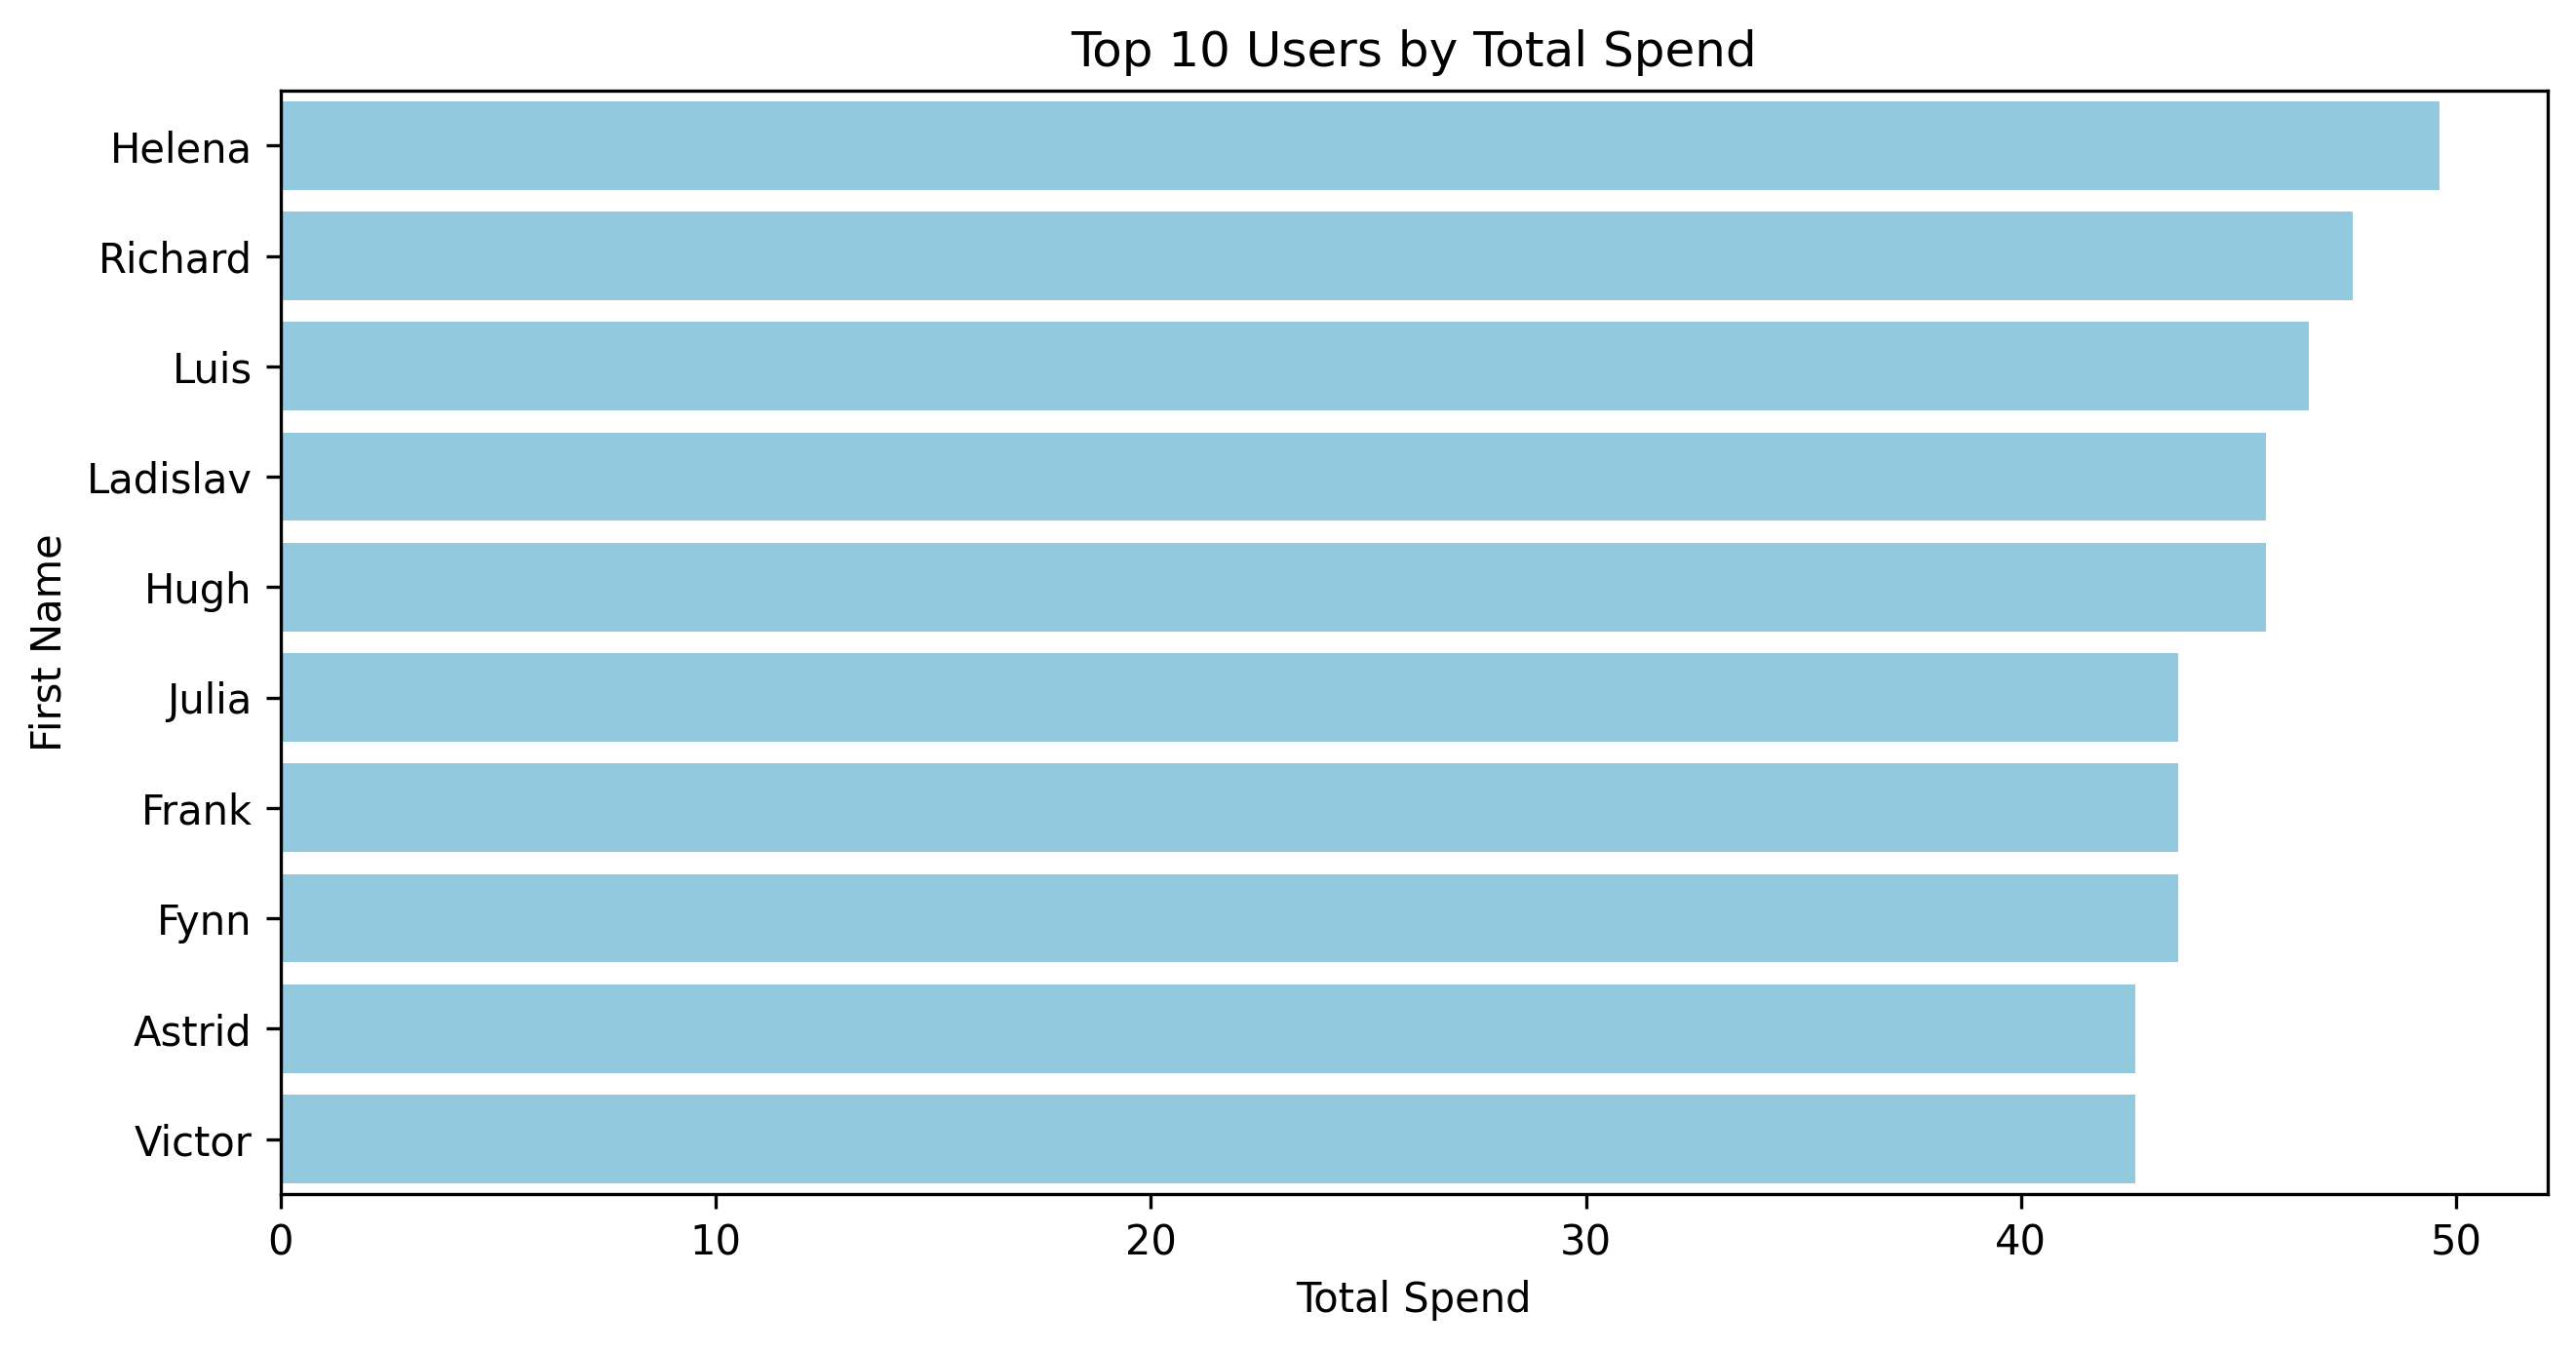

In [44]:
max_tries = 5
tries = 0
while tries < max_tries:
    try:
        exec(code)
        break
    except Exception as e:
        tries +=1
        print(Exception)